# Image Offsets: Create offset arrays used by drizzle

The offset tables created by a previous notebook (Offsets_2) are used to generate the X and Y offset arrays used by drizzle.

Each offset table will generate 2 arrays, for X and Y respectively, stored as FITS image extensions of short float type.

The algorithms were developed in the Timing notebook; here, they are cast as callable functions used in a loop to process all images in the sequence.

Originally this notebook was developed with the ISO 12800 data set as the test data. In the current version, it is configured to use the ISO 6400 data set. Statements specific to the original data set were comented out.

In [1]:
import os, glob
import time
import datetime

import multiprocessing as mp
from multiprocessing import Pool

import numpy as np

import scipy.ndimage.filters
from scipy.ndimage import convolve as convolve_scipy

from astropy.table import Table
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from astropy.io import fits

import rawpy

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from datapath import DATA
from worker import Worker

# %pylab notebook
# %matplotlib notebook

In [2]:
# datadir = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light/')
# datadir = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/6400/light/')
datadir = os.path.join(DATA,'astrophotography_data/Andromeda_2022/135mm16s6400ISO/')

## Functions

In [3]:
# The offset computation for each individual pixel is prohibitive without parallelization.
#
# The Worker class used to paralelize code must be declared in an imported file to prevent 
# errors of form: AttributeError: Can't get attribute 'Worker' on <module '__main__

def compute_offset_arrays(image, offsets_table):
    ''' Function to compute offset arrays with a first pass that parallelizes the
        algorithm, and a second pass that interpolates with convolution.
        
        Parameters:

        image - image array, used to figure out its shape
        offsets_table - astropy Table with offsets for each star (created by script Offsets_2.ipynb)
        
        Returns:

        output arrays with X and Y offsets
    '''    
    # get relevant offset information from table
    centroid_x_column = offsets_table['xcentroid'].data
    centroid_y_column = offsets_table['ycentroid'].data 
    offset_x_column   = offsets_table['xoffset'].data 
    offset_y_column   = offsets_table['yoffset'].data    
    
    # this makes indices consistent with daofind-defined centroids
    nx = image.shape[1]
    ny = image.shape[0]

    # work arrays for the parallelized code. These are filled up by
    # the callback function below.
    offset_array_x = np.asarray(image) * 0.0
    offset_array_y = np.asarray(image) * 0.0

    # callback function to collect results from parallel workers
    def collect_result(results):
        rx0 = results['x0']
        ry0 = results['y0']
        sx = results['size_x']
        sy = results['size_y']

        offset_array_section_x = results['offset_array_x']
        offset_array_section_y = results['offset_array_y']

        offset_array_x[ry0:ry0+sy,rx0:rx0+sx] = offset_array_section_x
        offset_array_y[ry0:ry0+sy,rx0:rx0+sx] = offset_array_section_y
    
    # number of processors
    nproc = 8    # (Mac M1)

    # To save time, we interpolate on the image array with a stride > 1 over both X and Y. 
    # The remaining pixels are filled in a subsequent step by regular interpolation from 
    # neighboring pixels. Using stride=3 and a 9x9 kernel ensures that enough data is used 
    # to interpolate.
    step = 3

    results = []
    pool = Pool(nproc)

    for p in range(nproc):
        # workers are defined over "vertical" sections of an image. Sections span a range
        # of X coordinates, but use the entire range of Y coordinates. Other combinations
        # could be used in case we want a different partitioning in between image sections.
        worker = Worker(int(p*nx/nproc), 0, int(nx/nproc), ny, step, step, 
                        centroid_x_column, centroid_y_column, 
                              offset_x_column, offset_y_column)

        r = pool.apply_async(worker, callback=collect_result)
        results.append(r)

    for r in results:
        r.wait()

    pool.close()

    # fill remaining pixels by interpolation
    offset_array_x[offset_array_x == 0.0] = np.nan
    offset_array_y[offset_array_y == 0.0] = np.nan

    kernel = Gaussian2DKernel(x_stddev=1)

    result_x = interpolate_replace_nans(offset_array_x, kernel)
    result_y = interpolate_replace_nans(offset_array_y, kernel)

    result_x[np.isnan(result_x)] = 0.
    result_y[np.isnan(result_y)] = 0.
    
    return result_x, result_y


def write_offsets_arrays(offsets_table, x_offsets, y_offsets):
    ''' Function to write the X and Y offsets arrays as FITS extensions
        in a FITS file. 
    '''
    today = datetime.datetime.now().ctime()
    
    offsets_name = offsets_table.replace('.offsets_table_clean.fits', '.offsets.fits')

    print("Writing offsets arrays: ", offsets_name, today)

    # Create FITS 2-extension 32-bit floating point file with offset arrays
    hdr = fits.Header()
    hdr['DATE'] = today
    hdr['PATH'] = offsets_name
    primary_hdu = fits.PrimaryHDU(header=hdr)

    x_hdu   = fits.ImageHDU(x_offsets.astype('float32'))
    y_hdu = fits.ImageHDU(y_offsets.astype('float32'))

    x_hdu.header['BAND'] = 'X offsets'
    y_hdu.header['BAND'] = 'Y offsets'

    hdul = fits.HDUList([primary_hdu, x_hdu, y_hdu])
    hdul.writeto(offsets_name, overwrite=True)
    
    return offsets_name

### Plots and diagnostics

We want the offsets to have smooth behavior: specifically, no sudden jumps should be present in the offset values. Beware of any pixel-to-pixel jump larger than 1! 

In [4]:
def plot_diagnostics(offsets_x, offsets_y, lrange=0.5):
    # Laplacian kernel
    A = np.zeros((3,3))
    A[1,1] = 1
    kernel = scipy.ndimage.filters.laplace(A)

    laplacian_x = convolve_scipy(offsets_x, kernel, mode='mirror')
    laplacian_y = convolve_scipy(offsets_y, kernel, mode='mirror')
    
    # plot everything
    cmap = 'bwr'

    fig = plt.figure(figsize=(9.5,7))

    a = fig.add_subplot(2, 2, 1)
    plt.imshow(offsets_x)
    plt.colorbar()
    a.set_title('X offsets')

    a1 = fig.add_subplot(2, 2, 2, sharex=a, sharey=a)
    plt.imshow(offsets_y)
    plt.colorbar()
    _ = a1.set_title('Y offsets')

    a2 = fig.add_subplot(2, 2, 3, sharex=a, sharey=a)
    plt.imshow(laplacian_x, cmap=cmap, vmin=-lrange, vmax=lrange)
    plt.colorbar()
    _ = a2.set_title('X Laplacian')

    a3 = fig.add_subplot(2, 2, 4, sharex=a, sharey=a)
    plt.imshow(laplacian_y, cmap=cmap, vmin=-lrange, vmax=lrange)
    plt.colorbar()
    _ = a3.set_title('Y Laplacian')

## Read last table in sequence, and read prototype image

Starting with the last table ensures that we get always the same stars along the entire sequence. Offset tables at the beginning of the sequence may include stars that are dropped later on.

In [5]:
table_list = glob.glob(datadir + '*.offsets_table_clean.fits')
table_list.sort()

# table_list = list(reversed(table_list))   # ISO 6400 data set

last = table_list[-1]
print(last)

offsets_table = Table.read(str(last))

/Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04697.offsets_table_clean.fits


We read one image in the sequence, just to get its dimensions. The output arrays have the same size as the image.

In [6]:
image_name = last.split('/')[-1]
image_name = image_name.replace('.offsets_table_clean.fits', '.ARW')
image_name = os.path.join(datadir, image_name)
raw = rawpy.imread(image_name)
imarray = raw.raw_image_visible.astype(float)

## Compute offsets for last table/image

In [7]:
t1 = time.time()
offsets_x, offsets_y = compute_offset_arrays(imarray, offsets_table)
t2 = time.time()
print("compute_offset_arrays: " , (t2-t1), " sec.")

compute_offset_arrays:  22.90988278388977  sec.


/var/folders/y5/zcwj7zc17g19nggvb1vx4rc80000gn/T/ipykernel_10326/514424243.py:5: DeprecationWarning: Please use `laplace` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  kernel = scipy.ndimage.filters.laplace(A)


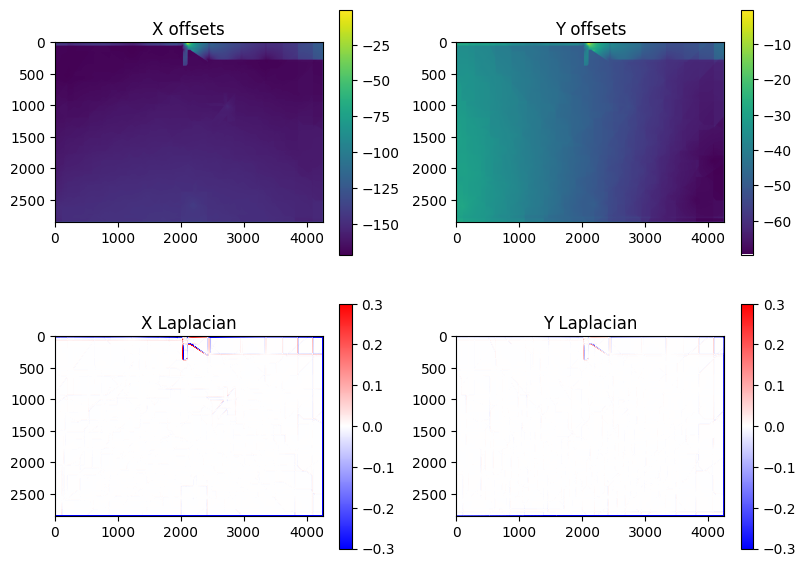

In [8]:
plot_diagnostics(offsets_x, offsets_y, lrange=0.3)

## Write offset arrays as FITS files

In [9]:
offsets_name = write_offsets_arrays(last, offsets_x, offsets_y)

Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04697.offsets.fits Sat Aug 12 18:31:52 2023


In [10]:
# test that the file is as expected
f = fits.open(offsets_name)
print(f[1].header)
x = f[1].data
print(f[2].header)
y = f[2].data

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 4256                                                  NAXIS2  =                 2848                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               BAND    = 'X offsets'                                                           END                                                                                                                                                                                                                                                                                                                                                                     

/var/folders/y5/zcwj7zc17g19nggvb1vx4rc80000gn/T/ipykernel_10326/514424243.py:5: DeprecationWarning: Please use `laplace` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  kernel = scipy.ndimage.filters.laplace(A)


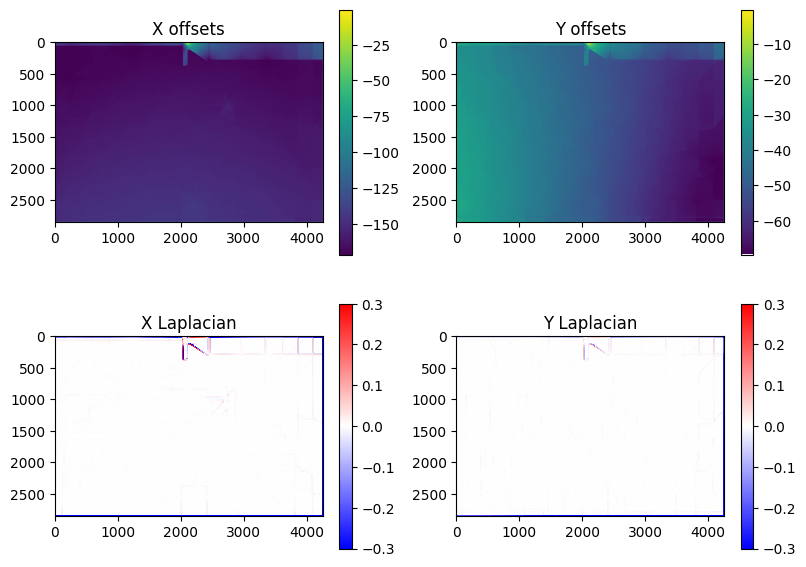

In [11]:
plot_diagnostics(x, y, lrange=0.3)

## Process entire sequence

In [12]:
# we skip the last table since it was processed already

for table_name in table_list[:-1]:
    offsets_table = Table.read(str(table_name))
    
    offsets_x, offsets_y = compute_offset_arrays(imarray, offsets_table)
    
    offsets_name = write_offsets_arrays(table_name, offsets_x, offsets_y)
    
#     plot_diagnostics(offsets_x, offsets_y, lrange=0.3)

Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03798.offsets.fits Sat Aug 12 18:32:21 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03799.offsets.fits Sat Aug 12 18:32:47 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03800.offsets.fits Sat Aug 12 18:33:19 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03801.offsets.fits Sat Aug 12 18:33:44 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03802.offsets.fits Sat Aug 12 18:34:13 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03803.offsets.fits Sat Aug 12 18:34:39 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03804.offsets.f

Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03854.offsets.fits Sat Aug 12 18:56:32 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03855.offsets.fits Sat Aug 12 18:56:57 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03856.offsets.fits Sat Aug 12 18:57:28 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03857.offsets.fits Sat Aug 12 18:57:54 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03858.offsets.fits Sat Aug 12 18:58:18 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03859.offsets.fits Sat Aug 12 18:58:41 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03860.offsets.f

Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03910.offsets.fits Sat Aug 12 19:18:52 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03911.offsets.fits Sat Aug 12 19:19:16 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03912.offsets.fits Sat Aug 12 19:19:40 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03913.offsets.fits Sat Aug 12 19:20:03 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03914.offsets.fits Sat Aug 12 19:20:26 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03915.offsets.fits Sat Aug 12 19:20:48 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03916.offsets.f

Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03966.offsets.fits Sat Aug 12 19:40:42 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03967.offsets.fits Sat Aug 12 19:41:06 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03968.offsets.fits Sat Aug 12 19:41:29 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03969.offsets.fits Sat Aug 12 19:41:51 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03970.offsets.fits Sat Aug 12 19:42:14 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03971.offsets.fits Sat Aug 12 19:42:37 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC03972.offsets.f

Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04022.offsets.fits Sat Aug 12 20:02:26 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04023.offsets.fits Sat Aug 12 20:02:49 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04024.offsets.fits Sat Aug 12 20:03:12 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04025.offsets.fits Sat Aug 12 20:03:37 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04026.offsets.fits Sat Aug 12 20:04:00 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04027.offsets.fits Sat Aug 12 20:04:23 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04028.offsets.f

Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04078.offsets.fits Sat Aug 12 20:24:21 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04079.offsets.fits Sat Aug 12 20:24:44 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04080.offsets.fits Sat Aug 12 20:25:07 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04081.offsets.fits Sat Aug 12 20:25:32 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04082.offsets.fits Sat Aug 12 20:25:56 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04083.offsets.fits Sat Aug 12 20:26:20 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04084.offsets.f

Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04134.offsets.fits Sat Aug 12 20:46:15 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04135.offsets.fits Sat Aug 12 20:46:38 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04136.offsets.fits Sat Aug 12 20:47:02 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04137.offsets.fits Sat Aug 12 20:47:27 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04138.offsets.fits Sat Aug 12 20:47:51 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04139.offsets.fits Sat Aug 12 20:48:14 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04140.offsets.f

Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04190.offsets.fits Sat Aug 12 21:08:11 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04191.offsets.fits Sat Aug 12 21:08:34 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04192.offsets.fits Sat Aug 12 21:08:56 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04193.offsets.fits Sat Aug 12 21:09:20 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04194.offsets.fits Sat Aug 12 21:09:43 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04195.offsets.fits Sat Aug 12 21:10:08 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04196.offsets.f

Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04246.offsets.fits Sat Aug 12 21:30:11 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04247.offsets.fits Sat Aug 12 21:30:34 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04248.offsets.fits Sat Aug 12 21:30:58 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04249.offsets.fits Sat Aug 12 21:31:22 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04250.offsets.fits Sat Aug 12 21:31:45 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04251.offsets.fits Sat Aug 12 21:32:10 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04252.offsets.f

Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04302.offsets.fits Sat Aug 12 21:52:02 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04303.offsets.fits Sat Aug 12 21:52:25 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04304.offsets.fits Sat Aug 12 21:52:48 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04305.offsets.fits Sat Aug 12 21:53:12 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04306.offsets.fits Sat Aug 12 21:53:35 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04307.offsets.fits Sat Aug 12 21:53:58 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04308.offsets.f

Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04358.offsets.fits Sat Aug 12 22:13:51 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04359.offsets.fits Sat Aug 12 22:14:14 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04360.offsets.fits Sat Aug 12 22:14:37 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04361.offsets.fits Sat Aug 12 22:14:59 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04362.offsets.fits Sat Aug 12 22:15:23 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04363.offsets.fits Sat Aug 12 22:15:46 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04364.offsets.f

Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04414.offsets.fits Sat Aug 12 22:35:39 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04415.offsets.fits Sat Aug 12 22:36:02 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04416.offsets.fits Sat Aug 12 22:36:26 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04417.offsets.fits Sat Aug 12 22:36:49 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04418.offsets.fits Sat Aug 12 22:37:12 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04419.offsets.fits Sat Aug 12 22:37:36 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04420.offsets.f

Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04470.offsets.fits Sat Aug 12 22:57:42 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04471.offsets.fits Sat Aug 12 22:58:05 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04472.offsets.fits Sat Aug 12 22:58:27 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04473.offsets.fits Sat Aug 12 22:58:51 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04474.offsets.fits Sat Aug 12 22:59:14 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04475.offsets.fits Sat Aug 12 22:59:39 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04476.offsets.f

Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04526.offsets.fits Sat Aug 12 23:19:30 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04527.offsets.fits Sat Aug 12 23:19:53 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04528.offsets.fits Sat Aug 12 23:20:16 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04529.offsets.fits Sat Aug 12 23:20:38 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04530.offsets.fits Sat Aug 12 23:21:03 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04531.offsets.fits Sat Aug 12 23:21:25 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04532.offsets.f

Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04582.offsets.fits Sat Aug 12 23:41:05 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04583.offsets.fits Sat Aug 12 23:41:28 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04584.offsets.fits Sat Aug 12 23:41:52 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04585.offsets.fits Sat Aug 12 23:42:17 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04586.offsets.fits Sat Aug 12 23:42:40 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04587.offsets.fits Sat Aug 12 23:43:03 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04588.offsets.f

Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04638.offsets.fits Sun Aug 13 00:03:06 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04639.offsets.fits Sun Aug 13 00:03:31 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04640.offsets.fits Sun Aug 13 00:03:55 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04641.offsets.fits Sun Aug 13 00:04:19 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04642.offsets.fits Sun Aug 13 00:04:42 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04643.offsets.fits Sun Aug 13 00:05:06 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04644.offsets.f

Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04694.offsets.fits Sun Aug 13 00:25:03 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04695.offsets.fits Sun Aug 13 00:25:25 2023
Writing offsets arrays:  /Users/busko/Projects/astrophotography_data/Andromeda_2022/135mm16s6400ISO/DSC04696.offsets.fits Sun Aug 13 00:25:48 2023
